# Swim through droplets

This notebook concerns the experiment of bacteria swimming through dense 2 um oil droplets, as illustrated below.

![runners leave trails](../images/2022/04/runners-leave-trails.png)

We are focusing on two phenomena: i) speed increase of individual bacterium in the presence of droplets, ii) cluster formation of droplets induced by bacterial swimming. The first phenomenon will be investigated using 3D tracker and the second will be studied using confocal microscope.

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import os
from matplotlib.patches import Ellipse
from myImageLib import readdata, bestcolor
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import cm, colors

## 0 Experimental setup

We print a square swimming pool of height ~180 $\mu$m using SU-8 2075 (MicroChem) on a borofloat glass wafer (Siegert Wafer). The droplets are fabricated by pressing 1-bromododecane through a porous ceramic membrane with 0.6 $\mu$m pores. The density of 1-bromododecane is 1.038 g/ml and is ideal for matching water/bacteria density. Below is a sketch of the experimental system, where the square swimming pool is filled with oil droplets:

![](../images/2022/05/droplet-swimming-pool.png)

We study the swimming of _E. coli_ bacteria in this system.

### 0.1 Density matching

We have previously used a silicone oil, which is much lighter than water, to fabricate droplets. In an experiment, most droplets float to the top surface of the swimming pool, leading to 0 effective volume of the droplet media. To make the droplet-media 3D, we want to match the density of oil with water, so that droplets no longer float to the top. 

It is hard to find an exact match of water density. Luckily, we can adjust water density with Percoll (1.2 g/ml), and this is biocompatible. With Percoll, we are able to do exact matching, as long as we do correct calculation. 

When fabricated, the oil droplets are suspended in water, with know initial volume fraction $f_o=20\%$. The densities of water, oil and Percoll are $\rho_w=1$, $\rho_o=1.038$ and $\rho_p=1.2$ g/ml, respectively.

We take $x$ $\mu$l droplet suspension, and assume that the density of droplets can be matched by adding $y$ $\mu$l Percoll, we have
$$
\frac{(1-f_o)x\rho_w + \rho_p y}{(1-f_o)x + y} = \rho_o.
$$

This leads to a relation between $x$ and $y$:
$$
y = (1-f_o)\frac{\rho_w - \rho_o}{\rho_o - \rho_p}x.
$$
This is implemented as a script below for future use.

In [58]:
oil_suspension_volume = 50 # ul
oil_volume_fraction = .2
rho_water = 1 # g/ml
rho_oil = 1.038 # g/ml
rho_percoll = 1.2 # g/ml

percoll_volume = (1-oil_volume_fraction) * (rho_water-rho_oil) / (rho_oil-rho_percoll) * oil_suspension_volume
print("Percoll to be added: {:.1f} ul".format(percoll_volume))

Percoll to be added: 9.4 ul


### 0.2 Droplet number profile

To characterize the droplet-media, we measure the droplet number profile along the vertical direction $z$. We use particle tracking (TrackMate in ImageJ) and mean intensity (since droplets are fluorescent). Two methods turned out to give very similar results. The raw data is obtained by scanning the sample along $z$. 3 snapshots at $z=9,84,168\,$$\mu$m are shown below, along with particle tracking results.

![](../images/2022/05/zscan-snapshots.png)

Near the bottom ($z=0$), most of the bright spots detected are bacteria. As we approach the middle plane ($z=84$), droplets start to dominate. Near the top surface ($z=168$), although we still see a few droplets, they are in very poor contrast with the background noise. This is likely because the dense droplet layer scatters the light. 

In [12]:
# load tracking results
particles = pd.read_csv(r"C:\Users\liuzy\Desktop\export.csv")

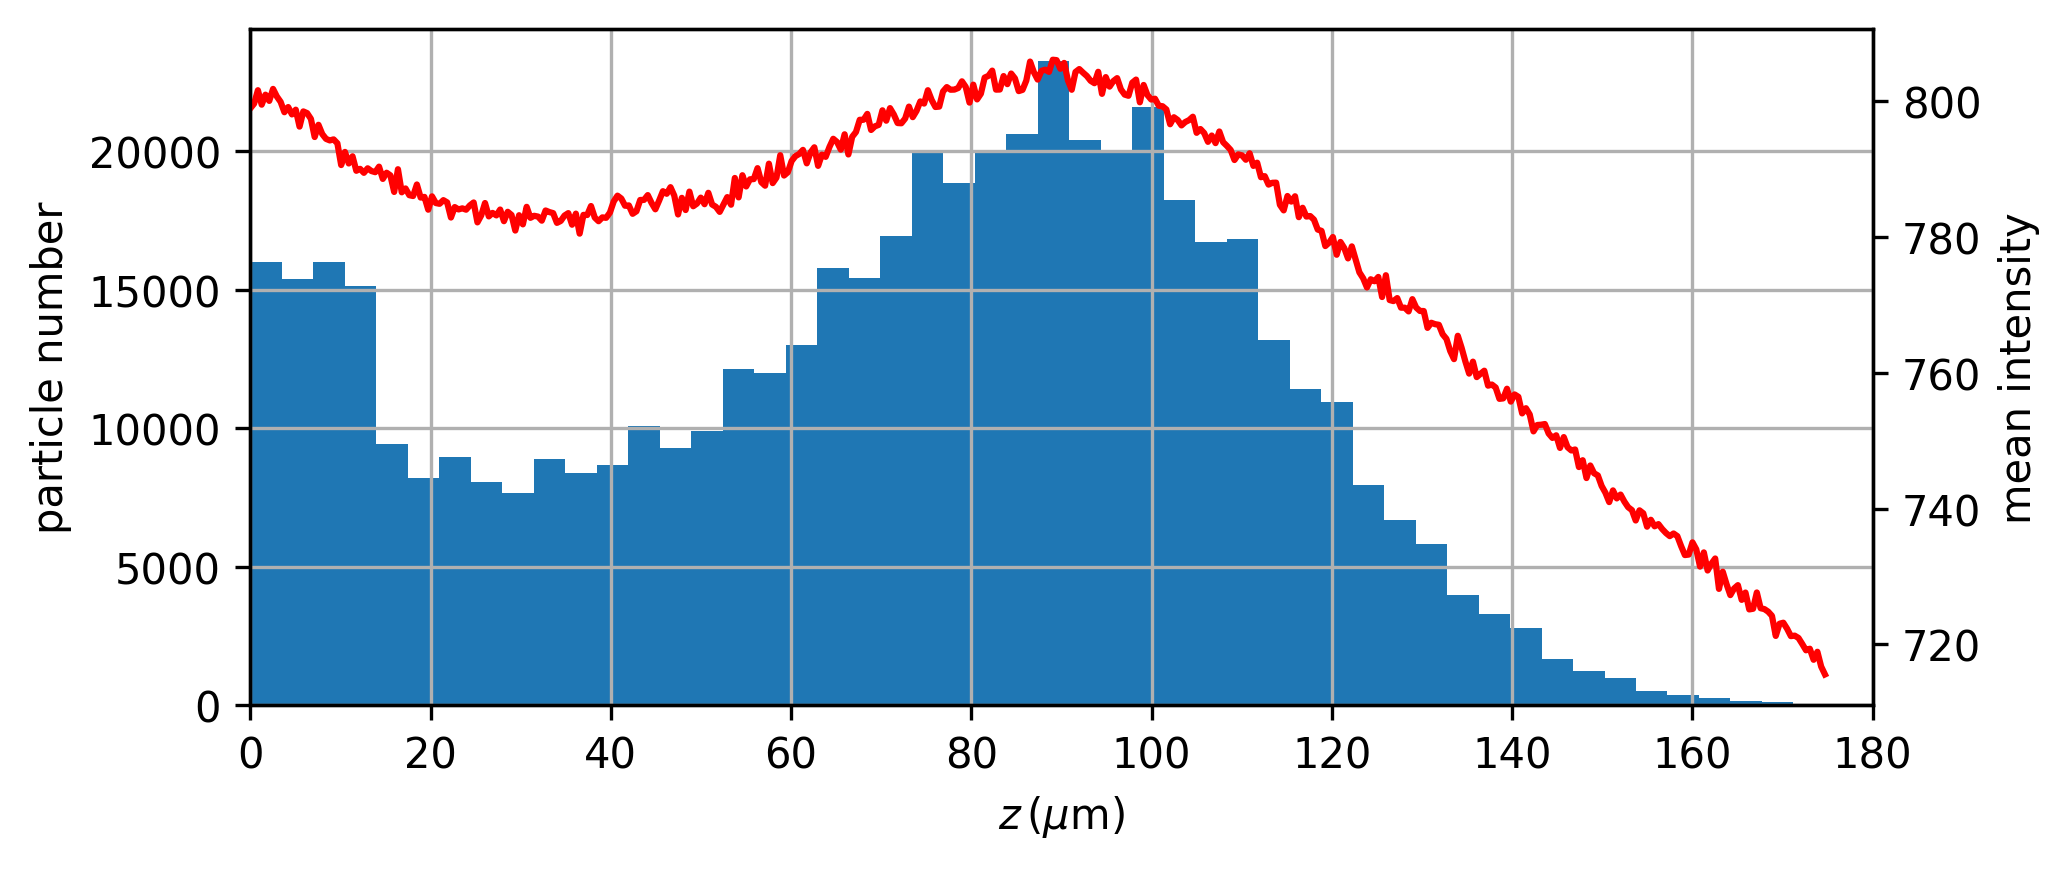

In [53]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=300)
(particles.FRAME*0.3*1.4).hist(bins=50) # note that 0.3 is the z-scan step length, and 1.4 is the dry lens refraction correction
ax.set_xlabel("$z\,$($\mu$m)")
ax.set_ylabel("particle number")
ax.set_xlim([0, 180])

# mean image intensity profile in z
folder = r"D:\droplet-wall\05182022-bacteria-droplet-zscan\raw"
l = readdata(folder, "tif")

mean_list = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    mean = img.mean()
    mean_list.append(mean)

ax1 = ax.twinx()
ax1.plot(np.arange(len(mean_list))*0.3*1.4, mean_list, color="red") # note that 0.3 is the z-scan step length, and 1.4 is the dry lens refraction correction
ax1.set_ylabel("mean intensity")

plt.tight_layout()
fig.savefig(r"C:\Users\liuzy\Desktop\profile.jpg")

**NOTE** that the profile shown above is from an experiment where I use 64 $\mu$l Percoll to match the density of 50 $\mu$l droplet suspension (20\%). This is a wrong calculation, leading to much higher suspending fluid density, which floats the droplets. New calculation suggests that 9.4 $\mu$l, instead of 64 $\mu$l, is needed to match this density. We will try the new calculation and see if it gives better density matching.

## 1 3-D trajectories

With the 3-D tracker, we are able to obtain some 3-D trajectories of bacteria swimming through the dense droplet-media. All the trajectories started from the bottom substrate of the swimming pool, because the image quality is better at the bottom and is getting worse when looking through the dense droplet layer, which scatters a lot of light. 

### 1.1 Load 3-D trajectory

In [4]:
folder = r"D:\05192022\2022-05-19_11h47m51s itsthisone"

In [5]:
traj = pd.read_csv(os.path.join(folder, "Track", "Track.txt"), usecols=[0,1,2,3], sep="\t", names=["frame", "x", "y", "z"])
with open(os.path.join(folder, "RawImageInfo.txt"), "r") as f:
    fps = int(f.readline())
print("The trajectory is {0:.1f} seconds long, shot at {1:d} frames per second.".format(len(traj)/fps, fps)) 

The trajectory is 52.7 seconds long, shot at 30 frames per second.


### 1.2 Some corrections
- Shift the starting point of the trajectory to (0, 0)
- Shift the trajectory to make min(z) = 0

In [6]:
traj_c = traj - [0, traj.x.loc[0], traj.y.loc[0], traj.z.min()]

### 1.3 Plot trajectory
Follow Renaud's plot convention:
- distinguish boundary and bulk
- draw a frame box to indicate the chamber

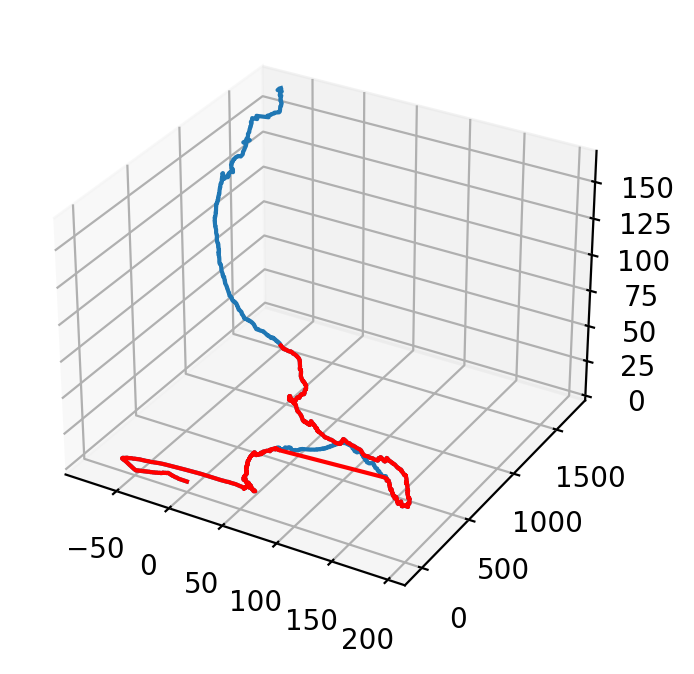

In [7]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj_c.x, traj_c.y, traj_c.z)

traj_b = traj_c.loc[traj_c.z < 50]
ax.plot(traj_b.x, traj_b.y, traj_b.z, color="red")

<IPython.core.display.Javascript object>


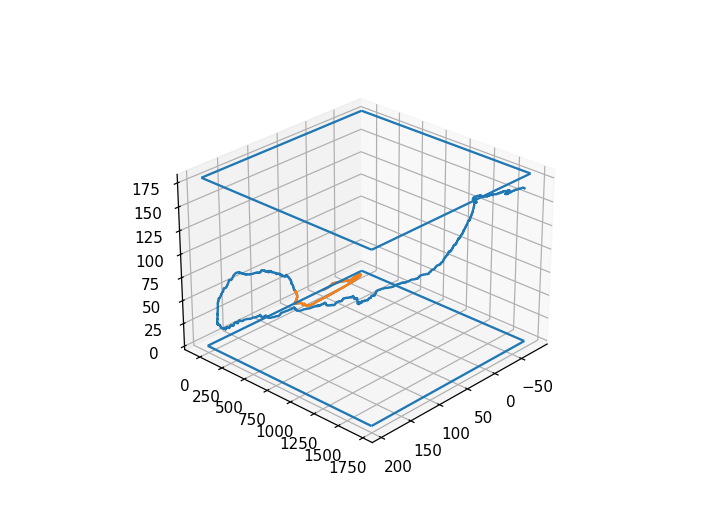

In [77]:
%matplotlib notebook
x = [traj_c.x.min(), traj_c.x.max()]
y = [traj_c.y.min(), traj_c.y.max()]
z = [traj_c.z.min(), traj_c.z.min()]
z1 = [180, 180]

X, Y = np.meshgrid(x, y)
Z = np.broadcast_to(np.array(z), X.shape)
Z1 = np.broadcast_to(np.array(z1), X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plot 2 rectangles
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=10)
# plot trajectory
ax.plot(traj_c.x, traj_c.y, traj_c.z)
traj_b = traj_c.loc[traj_c.z < 20]
ax.plot(traj_b.x, traj_b.y, traj_b.z, color=bestcolor(1))

# ax.view_init(elev=10, azim=20)

- `%matplotlib notebook` enables interactive 3-D plot, so I can see the trajectory from different angles.
- There are other tools that provide similar functionality, e.g. `ipyvolume` and `plotly`. Refer to [this question](https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook/44165156#44165156) for more available resources.

### 1.4 Velocity

Calculating velocity from trajectory is straight forward. However, due to the noisy nature of the detection, some post processing may be needed for the velocity data to make sense. 

#### 1.4.1 Straightforward 2 point velocity

$$
v_i = \frac{|\mathbf{r_{i+1}}-\mathbf{r_{i}}|}{\Delta t}
$$

In [29]:
dif = traj_c.diff(1)
v = (dif.x ** 2 + dif.y ** 2 + dif.z ** 2) ** 0.5 / dif.frame * fps

<IPython.core.display.Javascript object>


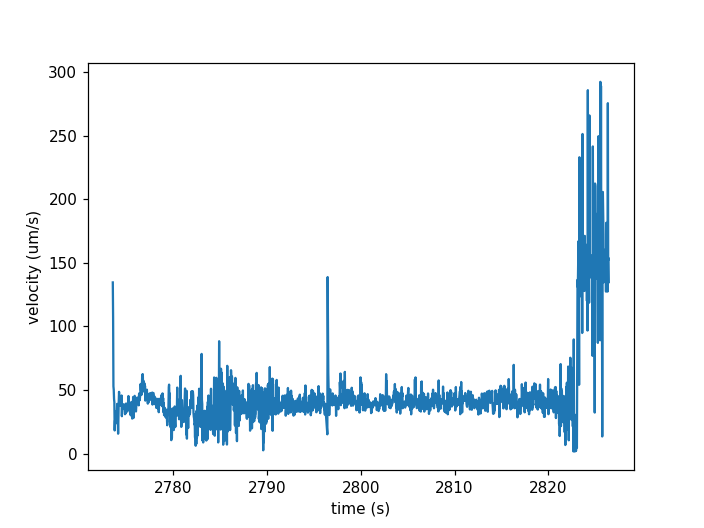

Text(0, 0.5, 'velocity (um/s)')

In [31]:
plt.plot(traj_c.frame/fps, v)
plt.xlabel("time (s)")
plt.ylabel("velocity (um/s)")

#### 1.4.2 Compare "more points" velocity
$$
v_i^n = \frac{|\mathbf{r_{i+n}}-\mathbf{r_{i}}|}{n\Delta t}
$$

<IPython.core.display.Javascript object>


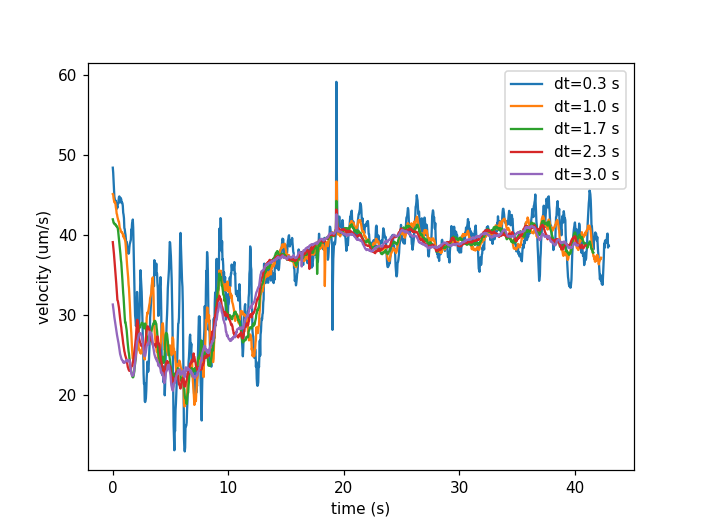

In [65]:
for n in range(10, 101, 20):
    dif = traj_c[100:1400].diff(n).dropna().reset_index()
    v = (dif.x ** 2 + dif.y ** 2 + dif.z ** 2) ** 0.5 / dif.frame * fps
    plt.plot(dif.index/fps, v, label="dt={:.1f} s".format(n/fps))
plt.xlabel("time (s)")
plt.ylabel("velocity (um/s)")
plt.legend()

$\Delta t = 2.3\,$s is a good choice. It follows the trend of 2-point velocity, while suppressing the big fluctuations. 

#### 1.4.3 Velocity probability distribution

<IPython.core.display.Javascript object>


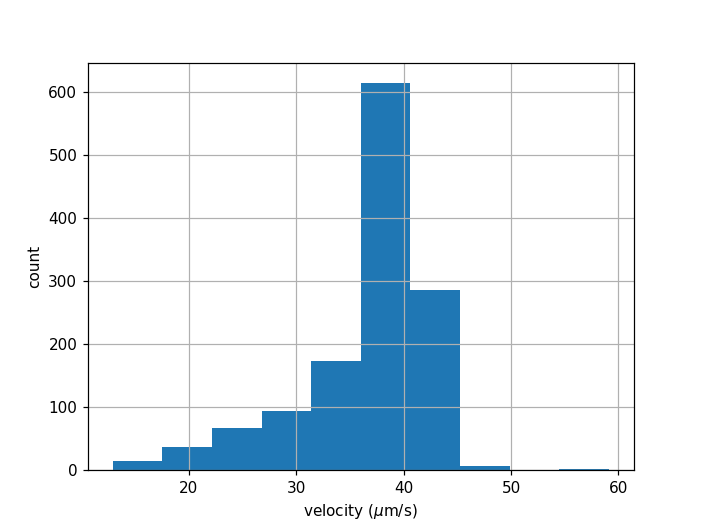

Text(0, 0.5, 'count')

In [96]:
traj_valid = traj_c[100:1400]
dif = traj_valid.diff(n).dropna().reset_index()
v = (dif.x ** 2 + dif.y ** 2 + dif.z ** 2) ** 0.5 / dif.frame * fps
v.hist()
plt.xlabel("velocity ($\mu$m/s)")
plt.ylabel("count")

In [114]:
np.percentile(v.dropna(), 95)

43.25420368871652

### 1.5 Velocity-position correlation

Due to the wrong density matching calculation, the droplets in our system tend to float, forming an increasing droplet concentration with height $z$ (likely an exponential function, reminescent to Boltzmann distribution in gravity potential). If bacterial velocity is correlated with surrounding droplets, the velocity will likely show a dependence on $z$. 

<IPython.core.display.Javascript object>


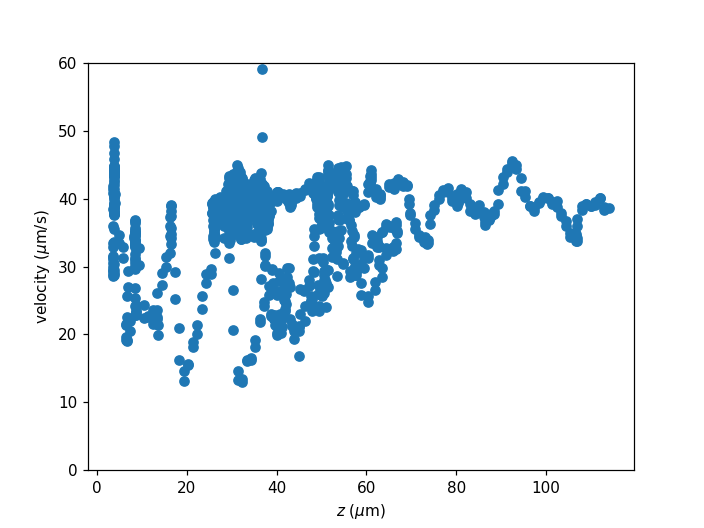

(0.0, 60.0)

In [76]:
n = 10
dif = traj_c[100:1400].diff(n).reset_index()
v = (dif.x ** 2 + dif.y ** 2 + dif.z ** 2) ** 0.5 / dif.frame * fps
plt.scatter(traj_c[100:1400].z, v)
plt.xlabel("$z$ ($\mu$m)")
plt.ylabel("velocity ($\mu$m/s)")
plt.ylim([0, 60])

#### 1.5.1 Color coded trajectory

Here I demonstrate a trajectory plot where the instantaneous velocity is coded by color. In the future, this template can be used for visualizing other quantities.

<IPython.core.display.Javascript object>


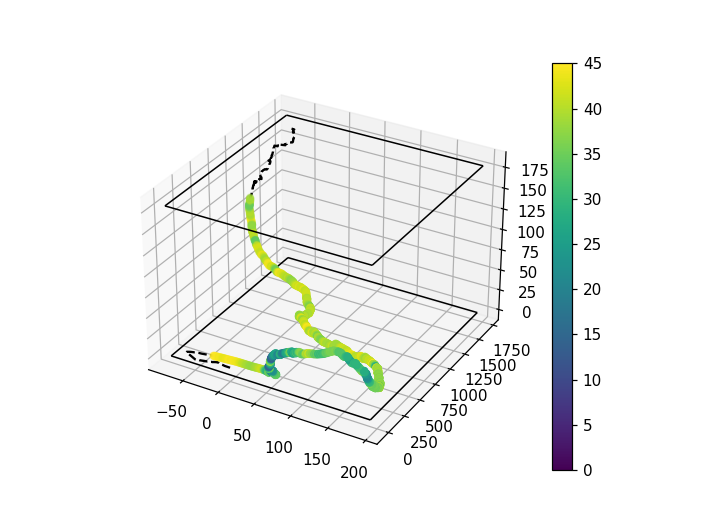

In [101]:
x = [traj_c.x.min(), traj_c.x.max()]
y = [traj_c.y.min(), traj_c.y.max()]
z = [traj_c.z.min(), traj_c.z.min()]
z1 = [180, 180]

X, Y = np.meshgrid(x, y)
Z = np.broadcast_to(np.array(z), X.shape)
Z1 = np.broadcast_to(np.array(z1), X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plot 2 rectangles
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, color="black", lw=1)
ax.plot_wireframe(X, Y, Z1, rstride=10, cstride=10, color="black", lw=1)
# plot trajectory
ax.plot(traj_c.x, traj_c.y, traj_c.z, ls="--", color="black")

n = 10
traj_valid = traj_c[100:1400]
dif = traj_valid.diff(n).reset_index()
v = (dif.x ** 2 + dif.y ** 2 + dif.z ** 2) ** 0.5 / dif.frame * fps
ax.scatter(traj_valid.x, traj_valid.y, traj_valid.z, c=v, vmin=0, vmax=45, cmap="viridis")

plt.colorbar(mappable=cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=45), cmap="viridis"), ax=ax)

### 1.6 All-in-one trajectory
This will include:
1. velocity evolution plot with various $\Delta t$ (to determine or justify best $\Delta t$)
2. velocity probability distribution plot, with 95% percentile indicator
3. velocity coded trajectory plot
4. velocity-position correlation plot

In [245]:
# load trajectory data
folder = r"D:\05192022\2022-05-19_15h48m09s-through-droplets"
traj = pd.read_csv(os.path.join(folder, "Track", "Track.txt"), usecols=[0,1,2,3], sep="\t", names=["frame", "x", "y", "z"])
with open(os.path.join(folder, "RawImageInfo.txt"), "r") as f:
    fps = int(f.readline())
traj = traj.assign(time=traj.index/fps).set_index("time")
traj_c = traj - [0, traj.x.loc[0], traj.y.loc[0], traj.z.min()]
print("The trajectory is {0:.1f} seconds long, shot at {1:d} frames per second.".format(len(traj)/fps, fps)) 

The trajectory is 101.1 seconds long, shot at 50 frames per second.


In [246]:
traj_valid = traj_c.loc[0: 95]
lag_n = 50 # lag time used for velocity calculation
vmax_percentile = 95

<IPython.core.display.Javascript object>


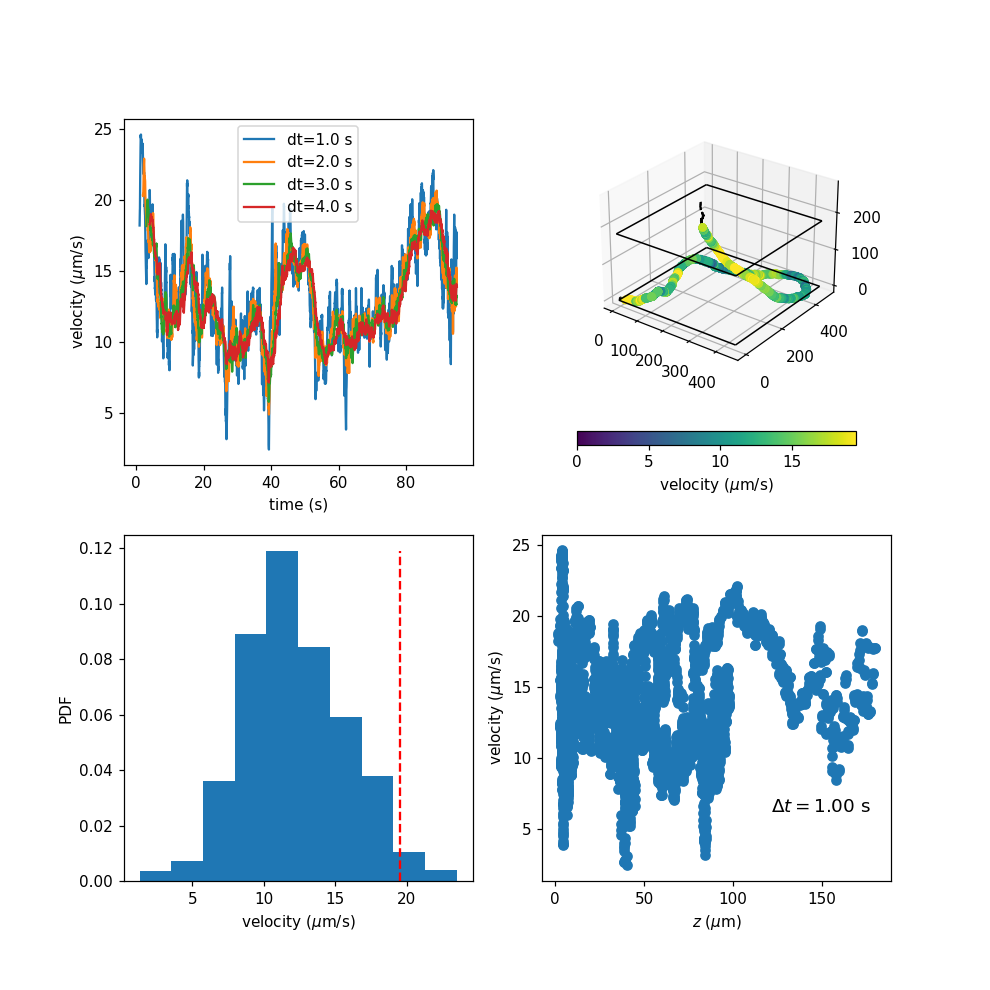

In [247]:
fig = plt.figure(figsize=(9, 9), dpi=100)

# velocity evolution plot with various dt
ax1 = fig.add_subplot(221)
for dt in range(1, 5):
    n = int(dt * fps)
    dif = traj_valid.diff(n)
    v = (dif.x ** 2 + dif.y ** 2 + dif.z ** 2) ** 0.5 / dif.frame * fps
    ax1.plot(dif.index, v, label="dt={:.1f} s".format(n/fps))
ax1.legend()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("velocity ($\mu$m/s)")

# trajectory plot 
ax2 = fig.add_subplot(222, projection='3d')
dif = traj_valid.diff(lag_n)
v = (dif.x ** 2 + dif.y ** 2 + dif.z ** 2) ** 0.5 / dif.frame * fps
vmax = np.percentile(v.dropna(), vmax_percentile)
## plot 2 rectangles
x = [traj_c.x.min(), traj_c.x.max()]
y = [traj_c.y.min(), traj_c.y.max()]
z = [traj_c.z.min(), traj_c.z.min()]
z1 = [180, 180]
X, Y = np.meshgrid(x, y)
Z = np.broadcast_to(np.array(z), X.shape)
Z1 = np.broadcast_to(np.array(z1), X.shape)
ax2.plot_wireframe(X, Y, Z, rstride=10, cstride=10, color="black", lw=1)
ax2.plot_wireframe(X, Y, Z1, rstride=10, cstride=10, color="black", lw=1)
## plot trajectory
ax2.plot(traj_c.x, traj_c.y, traj_c.z, ls="--", color="black")
## color code velocity
ax2.scatter(traj_valid.x, traj_valid.y, traj_valid.z, c=np.array(v), vmin=0, vmax=vmax, cmap="viridis")
plt.colorbar(mappable=cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=vmax), cmap="viridis"), 
             ax=ax2, shrink=0.8, fraction=0.1, orientation="horizontal", label="velocity ($\mu$m/s)")

# velocity distribution
ax3 = fig.add_subplot(223)
dif = traj_valid.diff(lag_n)
v = (dif.x ** 2 + dif.y ** 2 + dif.z ** 2) ** 0.5 / dif.frame * fps
hist, bin_edges = np.histogram(v.dropna(), density=True)
# a = v.hist(ax=ax3)
ax3.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0])
ax3.set_xlabel("velocity ($\mu$m/s)")
ax3.set_ylabel("PDF")
## indicate percentile
ax3.plot([vmax, vmax], [0, hist.max()], ls="--", color="red")

# velocity-position correlation
ax4 = fig.add_subplot(224)
ax4.scatter(traj_valid.z, v)
ax4.set_xlabel("$z$ ($\mu$m)")
ax4.set_ylabel("velocity ($\mu$m/s)")
ax4.annotate("$\Delta t={:.2f}$ s".format(lag_n/fps), (.8, .2), xycoords="axes fraction", size=12, horizontalalignment="center")

fig.savefig(os.path.join(folder, "traj_analysis.jpg"))

In [149]:
a

<AxesSubplot:xlabel='velocity ($\\mu$m/s)', ylabel='count'>